In [4]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import keras_tuner as kt
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
import random
import os
import seaborn as sn
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Juane/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Juane/Sentinel2LULC_Test.zip" -d "/content"

In [6]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [7]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)

Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [ ]:
## Estimación de los hiperparámetros del compilador

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  augmentation = Sequential([
        RandomFlip()
  ])
  base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
  base_model.trainable = False
  entrada = Input(shape=(224,224,3))
  prediction_layer = Dense(29, activation="softmax")
  model = Sequential([
    entrada,
    augmentation,
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    prediction_layer
  ])

  # Tuneamos el learning rate y el optimizador
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,0.1,
                                                        0.2, 0.3])
  hp_amsgrad = hp.Choice('amsgrad', values=[True,False])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate,amsgrad=hp_amsgrad),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy', 
                     max_epochs=25,
                     factor=3, 
                     directory="/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/",
                     project_name='khyperbandEfficientNetB2')

print(tuner.search_space_summary())

# Ejecutamos el tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training,validation_data=validation,epochs=25, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.get('learning_rate'))
print(best_hp.get('amsgrad'))

KeyboardInterrupt: ignored

31801344/31790344 [==============================] - 0s 0us/step


2022/03/21 14:32:20 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB2 con DataAugmentation (ImageNet)' does not exist. Creating a new experiment.


Epoch 1/100
257/257 [==============================] - 87s 253ms/step - loss: 1.6368 - accuracy: 0.5191 - val_loss: 1.3171 - val_accuracy: 0.6371
Epoch 2/100
257/257 [==============================] - 61s 237ms/step - loss: 1.0853 - accuracy: 0.6568 - val_loss: 0.9570 - val_accuracy: 0.6800
Epoch 3/100
257/257 [==============================] - 61s 238ms/step - loss: 0.9568 - accuracy: 0.6809 - val_loss: 0.8867 - val_accuracy: 0.7034
Epoch 4/100
257/257 [==============================] - 61s 238ms/step - loss: 0.8839 - accuracy: 0.7067 - val_loss: 0.8596 - val_accuracy: 0.7116
Epoch 5/100
257/257 [==============================] - 61s 238ms/step - loss: 0.8357 - accuracy: 0.7231 - val_loss: 0.8382 - val_accuracy: 0.7248
Epoch 6/100
257/257 [==============================] - 61s 237ms/step - loss: 0.7822 - accuracy: 0.7354 - val_loss: 0.8095 - val_accuracy: 0.7399
Epoch 7/100
257/257 [==============================] - 61s 237ms/step - loss: 0.7707 - accuracy: 0.7425 - val_loss: 0.7947 -

2022/03/21 14:54:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


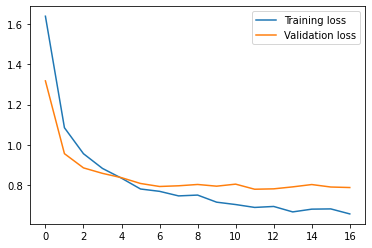

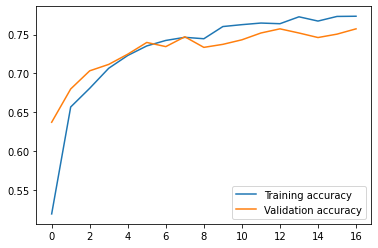

In [8]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])


## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=0.001, amsgrad=0)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/100
257/257 [==============================] - 245s 877ms/step - loss: 1.3327 - accuracy: 0.6229 - val_loss: 1.6800 - val_accuracy: 0.4998
Epoch 2/100
257/257 [==============================] - 221s 860ms/step - loss: 0.6878 - accuracy: 0.7775 - val_loss: 0.5183 - val_accuracy: 0.8164
Epoch 3/100
257/257 [==============================] - 221s 859ms/step - loss: 0.5209 - accuracy: 0.8239 - val_loss: 0.3865 - val_accuracy: 0.8660
Epoch 4/100
257/257 [==============================] - 222s 861ms/step - loss: 0.4208 - accuracy: 0.8538 - val_loss: 0.3340 - val_accuracy: 0.8807
Epoch 5/100
257/257 [==============================] - 222s 861ms/step - loss: 0.3608 - accuracy: 0.8745 - val_loss: 0.3481 - val_accuracy: 0.8714
Epoch 6/100
257/257 [==============================] - 222s 861ms/step - loss: 0.3047 - accuracy: 0.8935 - val_loss: 0.3548 - val_accuracy: 0.8753
Epoch 7/100
257/257 [==============================] - 221s 860ms/step - loss: 0.2727 - accuracy: 0.9042 - val_loss: 0

2022/03/21 16:12:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


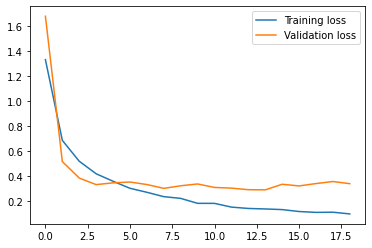

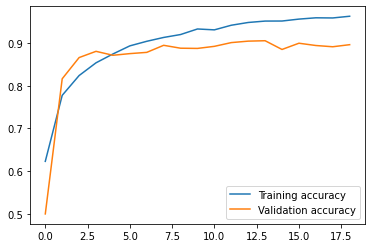

In [9]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
  for layer in model.layers[-26:]:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = True

  opt = Adam(learning_rate=1e-4)
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
              metrics=['accuracy'])
  
unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [10]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [11]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_ImageNet.csv', index=False)
files.download('EfficientNetB2_ImageNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

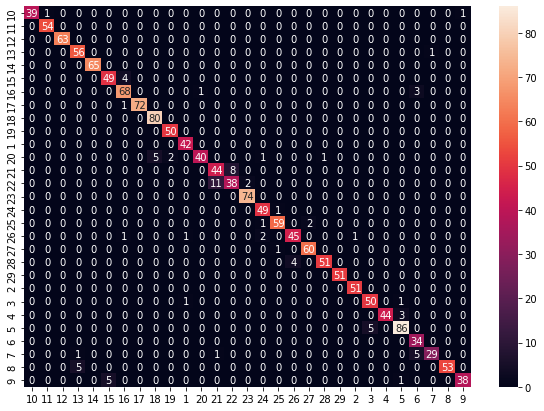

In [12]:
## Sacamos la matriz de confusion

clases = []
dirname = sorted(os.listdir("Sentinel2LULC_Test"))
for names in dirname:
  clases.append(names.split('_')[0])

clases = [int(x) for x in clases]

indexes = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)]

matrix = confusion_matrix(clases, list(classes),labels=indexes)

df_cm = pd.DataFrame(matrix, index = indexes, columns = indexes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)